# Permutation Testing

In [1]:
import os
from os.path import expanduser
home = expanduser("~")

import numpy as np
import pickle

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf

import hydra

#PyTorch
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

import pathlib
from torchsummary import summary
import sslearning 

import captum
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from captum.attr._utils.attribution import GradientAttribution, LayerAttribution
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule

from sslearning.models.accNet import SSLNET, Resnet
from sslearning.utils import load_weights_dist2norm, trans30two1
from downstream_task_evaluation import load_weights
from sslearning.data.data_loader import subject_dataset

import gc
cuda = torch.cuda.is_available()
gc.collect()
torch.cuda.empty_cache()
cudnn.benchmark = True

def set_seed():
    # For reproducibility
    random_seed = 42
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    cudnn.benchmark = True
    if cuda:
        torch.cuda.manual_seed_all(random_seed)
  
set_seed()
device = torch.device("cpu")

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Network Initilisation

In [2]:
config_dir = pathlib.Path('conf/')
hydra.initialize(config_path=config_dir)
cfg=compose(config_name="config.yaml")
cfg=compose(overrides= ["+model=resnet", "+dataloader=default", "+task=time_reversal", "++task.positive_ratio=0.5"])
cfg.dataloader.epoch_len=10

/home/scro3203/anaconda3/envs/ssl/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/home/scro3203/anaconda3/envs/ssl/lib/python3.9/site-packages/hydra/core/default_element.py:122: UserWarning: In 'dataloader/default': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more information
  deprecation_warning(
/home/scro3203/anaconda3/envs/ssl/lib/python3.9/site-packages/hydra/core/default_element.py:122: UserWarning: In 'augmentation/no_aug': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more information
  deprecation_warning(
/home/scro3203/anaconda3/envs/ssl/lib/python3.9/site-packa

In [3]:
print(cfg)

{'model': {'learning_rate': 0.0001, 'name': 'mtl_baseline_rotation${task.rotation}_time${task.time_reversal}_data${data.data_name}_lr${model.learning_rate}_resnet_v${model.resnet_version}_win_size${dataloader.epoch_len}_posR_${task.positive_ratio}', 'mixed_precision': False, 'resnet_version': 1, 'warm_up_step': 5, 'lr_scale': False}, 'dataloader': {'num_sample_per_subject': 500, 'sample_rate': 30, 'epoch_len': 10}, 'task': {'rotation': False, 'switch_axis': False, 'time_reversal': True, 'positive_ratio': 0.5}}


In [4]:
# Uncomment this for Andrew
model_name='final_model_10.mdl'
model_path = home + '/data/ssl/' + model_name
#model_path = '/data/UKBB/final_models/100k_epoch_30.mdl'

model = Resnet(output_size=2, cfg=cfg)
load_weights_dist2norm(model, model_path)
model.eval()

Resnet(
  (feature_extractor): Sequential(
    (layer1): Sequential(
      (0): Conv1d(3, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
      (1): ResBlock(
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (relu): ReLU(inplace=True)
      )
      (2): ResBlock(
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (conv2): Conv1d(6

## Helper dataset

In [5]:
print(cfg)

{'model': {'learning_rate': 0.0001, 'name': 'mtl_baseline_rotation${task.rotation}_time${task.time_reversal}_data${data.data_name}_lr${model.learning_rate}_resnet_v${model.resnet_version}_win_size${dataloader.epoch_len}_posR_${task.positive_ratio}', 'mixed_precision': False, 'resnet_version': 1, 'warm_up_step': 5, 'lr_scale': False}, 'dataloader': {'num_sample_per_subject': 500, 'sample_rate': 30, 'epoch_len': 10}, 'task': {'rotation': False, 'switch_axis': False, 'time_reversal': True, 'positive_ratio': 0.5}}


In [6]:
'''generate reversed data'''
#from sslearning.data.data_transformation import flip
#X_data_reverse = [flip(x, 1) for x in X_data_forward]
#X_data_reverse=np.asarray(X_data_reverse)
#Y_reverse=np.ones(X_data_reverse.shape[0]).astype(int)
'''Merge sample data'''
#X_data=np.vstack((X_data_forward,X_data_reverse))
#Y=np.hstack((Y_forward,Y_reverse))

'Merge sample data'

In [7]:
#X_data=torch.tensor(X_data, requires_grad=True)
#softmax = nn.Softmax(dim=1)
## Q: do we need requires grad?
#X_data=X_data.to(device, dtype=torch.float)

In [8]:
from sslearning.data.datautils import Transform
#from sslearning.utils import onehot

#Normalise the data between [-1,1]...
transform=Transform(transformations=['rescale'], channel_wise=False, limits=[-1, 1])
#or...: X_data=[transform(x) for x in X_data]

#dataset = Dataset(X_data, Y, transformation=transform, target_transformation=onehot(len(labels)))
#data_generator=DataLoader(dataset, batch_size=64, shuffle=False) 

In [9]:
from interpretability.attribution import Dataset, forward_by_batches

# Uncomment this for Andrew
sample_path = home + '/data/ssl/sample_subject.npy'
#sample_path = '/data/UKBB/SSL/mini_sample/5300274_90001_0_0.npy'

labels=['forward', 'reversed']

dataset = subject_dataset(sample_path, cfg)
data_generator=DataLoader(dataset, batch_size=64, shuffle=False) 

In [10]:
'''evaluate the model'''
## Option 1: Overall
'''
#Input shape should be: [batchSize x channels x time samples]
X_data=torch.tensor(X_data, requires_grad=True)
softmax = nn.Softmax(dim=1)
## Q: do we need requires grad?
X_data=X_data.to(device, dtype=torch.float)
logits=model(X_data)
prob = softmax(logits).cpu().detach().numpy()
Yfit=np.argmax(prob, axis=1).astype(int)
#return to numpy
X_data=X_data.cpu().detach().numpy()
'''

## Option 2: iterate over batches
Y, Yfit, _, prob=forward_by_batches(model, data_generator, device=device)


In [11]:
import sklearn.metrics as metrics
from sslearning.utils import compute_scores, print_scores, get_one_hot

print_scores(compute_scores(Y, Yfit))
#auroc=metrics.roc_auc_score(get_one_hot(Y,  prob.shape[1]), prob, average='macro', multi_class='ovr')

#print('AUROC', auroc)

Accuracy score: 0.979
Balanced accuracy score: 0.9790000000000001
Cohen kappa score: 0.958

Per-class recall scores:
sleep      : 0.9906666666666667
awake   : 0.9673333333333334

Confusion matrix:
 [[1486   14]
 [  49 1451]]


In [12]:
'''determine exemplary samples'''
#1. predicted correctly for forward and reversed samples
#2. high posterior probabilty for each prediction (>threshold)

X_data=dataset.X.cpu().detach().numpy()

threshold=0.85

all_mask=(Y==Yfit) & (np.max(prob, axis=1)>threshold)
print('Total # exemplary examples: {:} ({:.2f}%)'.format(all_mask.sum(), 100*all_mask.sum()/len(all_mask)))

fwd_idx=np.arange(0, len(X_data), 2)
rev_idx=np.arange(1, len(X_data), 2)

X_fwd=X_data[fwd_idx]
X_rev=X_data[rev_idx]

Y_fwd=Y[fwd_idx]
Y_rev=Y[rev_idx]

fwd_mask=(Y[fwd_idx]==Yfit[fwd_idx]) & (np.max(prob[fwd_idx], axis=1)>threshold)
rev_mask=(Y[rev_idx]==Yfit[rev_idx]) & (np.max(prob[rev_idx], axis=1)>threshold)

print('Total # exemplary (forward) examples:', fwd_mask.sum())
print('Total # exemplary (reverse) examples:', rev_mask.sum())

mask=(fwd_mask==True) & (rev_mask==True)

print('Total # exemplary (matched) examples: {:} ({:.2f}%)'.format(mask.sum(), 100*mask.sum()/len(mask)))

indexs=np.where(mask)[0]

Total # exemplary examples: 2838 (94.60%)
Total # exemplary (forward) examples: 1441
Total # exemplary (reverse) examples: 1397
Total # exemplary (matched) examples: 1392 (92.80%)


# Permutation Analysis

In [13]:
from interpretability.permutation import Dataset, permutation_analysis, PermutationMask
from sslearning.utils import onehot
from pathlib import Path 


PERM_SAVE_PATH=home + '/data/ssl/perm/new_analysis/'

#Python ≥ 3.5, see: https://stackoverflow.com/questions/273192/how-can-i-safely-create-a-nested-directory
Path(PERM_SAVE_PATH).mkdir(parents=True, exist_ok=True) 


#Normalise the data between [-1,1]...
transform=Transform(transformations=['rescale'], channel_wise=False, limits=[-1, 1])
#or...: X_data=[transform(x) for x in X_data]

X_perm=np.vstack((X_fwd[indexs],(X_rev[indexs])))
Y_perm=np.hstack((Y[fwd_idx][indexs],(Y[rev_idx][indexs])))

#X_perm=X_fwd[indexs]
#Y_perm=Y[fwd_idx][indexs]

X_perm=np.vstack((X_fwd[indexs],(X_rev[indexs])))
Y_perm=np.hstack((Y[fwd_idx][indexs],(Y[rev_idx][indexs])))

perm_dataset = Dataset(X_perm, Y_perm, target_transformation=onehot(len(labels)))
#make new generator and shuffle the labels
perm_data_generator=DataLoader(perm_dataset, batch_size=64, shuffle=True) 


In [14]:
'''set permutation analysis parameters'''
parameters={'sample_step': 25, 'sample_range_pc': 1, 'verbose': 1}

## 1. Random Permutation

In [15]:
'''
perm_random=permutation_analysis(model, perm_data_generator, [], mask=PermutationMask('noise'), random=True,  sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])
perm_random={**perm_random}

print('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_random4.pckl'))
with open(PERM_SAVE_PATH + 'perm_random4.pckl', 'wb') as tfile:
        pickle.dump(perm_random, tfile, pickle.HIGHEST_PROTOCOL)
'''

"\nperm_random=permutation_analysis(model, perm_data_generator, [], mask=PermutationMask('noise'), random=True,  sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])\nperm_random={**perm_random}\n\nprint('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_random4.pckl'))\nwith open(PERM_SAVE_PATH + 'perm_random4.pckl', 'wb') as tfile:\n        pickle.dump(perm_random, tfile, pickle.HIGHEST_PROTOCOL)\n"

## 2. LRP-e rule

In [16]:
'''
from captum.attr import LRP
from interpretability import attribution as attr
from interpretability.lrp_models import LRPEpsilonSSL,  _print_lrp_rules

lrp = LRP(model)
#apply epsilon rule to the model
lrp_rule=LRPEpsilonSSL(verbose=False)
model, _=lrp_rule(model)
_print_lrp_rules(model)

analysis_model_param={}
analysis_model={'algorithm': lrp, 'lrp_rule': lrp_rule, 'parameters': analysis_model_param}

perm_lrpe=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'), sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])

perm_lrpe={**perm_lrpe, **analysis_model_param}

print('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_lrpe.pckl'))
with open(PERM_SAVE_PATH + 'perm_lrpe.pckl', 'wb') as tfile:
        pickle.dump(perm_lrpe, tfile, pickle.HIGHEST_PROTOCOL)
'''

"\nfrom captum.attr import LRP\nfrom interpretability import attribution as attr\nfrom interpretability.lrp_models import LRPEpsilonSSL,  _print_lrp_rules\n\nlrp = LRP(model)\n#apply epsilon rule to the model\nlrp_rule=LRPEpsilonSSL(verbose=False)\nmodel, _=lrp_rule(model)\n_print_lrp_rules(model)\n\nanalysis_model_param={}\nanalysis_model={'algorithm': lrp, 'lrp_rule': lrp_rule, 'parameters': analysis_model_param}\n\nperm_lrpe=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'), sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])\n\nperm_lrpe={**perm_lrpe, **analysis_model_param}\n\nprint('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_lrpe.pckl'))\nwith open(PERM_SAVE_PATH + 'perm_lrpe.pckl', 'wb') as tfile:\n        pickle.dump(perm_lrpe, tfile, pickle.HIGHEST_PROTOCOL)\n"

## 3. LRP-0 rule

In [17]:
'''
from captum.attr import LRP
from interpretability import attribution as attr
from interpretability.lrp_models import LRPEpsilonSSL

lrp = LRP(model)
#apply epsilon rule to the model
lrp_rule=LRPEpsilonSSL(verbose=False, epsilon=0)
#apply composite rule to the model
model, _=lrp_rule(model)

analysis_model_param={}
analysis_model={'algorithm': lrp, 'lrp_rule': lrp_rule, 'parameters': analysis_model_param}

perm_lrp0=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'), sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])

perm_lrp0={**perm_lrp0, **analysis_model_param}

print('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_lrp0.pckl'))
with open(PERM_SAVE_PATH + 'perm_lrp0.pckl', 'wb') as tfile:
        pickle.dump(perm_lrp0, tfile, pickle.HIGHEST_PROTOCOL)
'''

"\nfrom captum.attr import LRP\nfrom interpretability import attribution as attr\nfrom interpretability.lrp_models import LRPEpsilonSSL\n\nlrp = LRP(model)\n#apply epsilon rule to the model\nlrp_rule=LRPEpsilonSSL(verbose=False, epsilon=0)\n#apply composite rule to the model\nmodel, _=lrp_rule(model)\n\nanalysis_model_param={}\nanalysis_model={'algorithm': lrp, 'lrp_rule': lrp_rule, 'parameters': analysis_model_param}\n\nperm_lrp0=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'), sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])\n\nperm_lrp0={**perm_lrp0, **analysis_model_param}\n\nprint('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_lrp0.pckl'))\nwith open(PERM_SAVE_PATH + 'perm_lrp0.pckl', 'wb') as tfile:\n        pickle.dump(perm_lrp0, tfile, pickle.HIGHEST_PROTOCOL)\n"

## 4. LRP-Alpha1Beta0 rule

In [18]:
'''
from captum.attr import LRP
from interpretability import attribution as attr
from interpretability.lrp_models import LRPEpsilonSSL, LRPEpsilon0SSL, LRPAlpha1Beta0SSL, LRPEpsilonBenchmark, _print_lrp_rules

lrp = LRP(model)
#apply Alpha1Beta0 rule to the model
lrp_rule=LRPAlpha1Beta0SSL(verbose=False)

analysis_model_param={}
analysis_model={'algorithm': lrp, 'lrp_rule': lrp_rule, 'parameters': analysis_model_param}

perm_lrpAB=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'), sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])

perm_lrpAB={**perm_lrpAB, **analysis_model_param}

print('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_lrpAB.pckl'))
with open(PERM_SAVE_PATH + 'perm_lrpAB.pckl', 'wb') as tfile:
        pickle.dump(perm_lrpAB, tfile, pickle.HIGHEST_PROTOCOL)
'''

"\nfrom captum.attr import LRP\nfrom interpretability import attribution as attr\nfrom interpretability.lrp_models import LRPEpsilonSSL, LRPEpsilon0SSL, LRPAlpha1Beta0SSL, LRPEpsilonBenchmark, _print_lrp_rules\n\nlrp = LRP(model)\n#apply Alpha1Beta0 rule to the model\nlrp_rule=LRPAlpha1Beta0SSL(verbose=False)\n\nanalysis_model_param={}\nanalysis_model={'algorithm': lrp, 'lrp_rule': lrp_rule, 'parameters': analysis_model_param}\n\nperm_lrpAB=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'), sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])\n\nperm_lrpAB={**perm_lrpAB, **analysis_model_param}\n\nprint('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_lrpAB.pckl'))\nwith open(PERM_SAVE_PATH + 'perm_lrpAB.pckl', 'wb') as tfile:\n        pickle.dump(perm_lrpAB, tfile, pickle.HIGHEST_PROTOCOL)\n"

## 5. LRP-CMP (composite) rule

In [19]:
'''
from captum.attr import LRP
from interpretability import attribution as attr
from interpretability.lrp_models import LRPEpsilonSSL, LRPCompositeSSL, LRPEpsilon0SSL, LRPAlpha1Beta0SSL, LRPEpsilonBenchmark, _print_lrp_rules

lrp = LRP(model)
#apply epsilon rule to the model
lrp_rule=LRPCompositeSSL(verbose=False)

analysis_model_param={}
analysis_model={'algorithm': lrp, 'lrp_rule': lrp_rule, 'parameters': analysis_model_param}

perm_lrp_cmp=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'),sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])

perm_lrp_cmp={**perm_lrp_cmp, **analysis_model_param}

print('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_lrp_cmp.pckl'))
with open(PERM_SAVE_PATH + 'perm_lrp_cmp.pckl', 'wb') as tfile:
        pickle.dump(perm_lrp_cmp, tfile, pickle.HIGHEST_PROTOCOL)
'''

"\nfrom captum.attr import LRP\nfrom interpretability import attribution as attr\nfrom interpretability.lrp_models import LRPEpsilonSSL, LRPCompositeSSL, LRPEpsilon0SSL, LRPAlpha1Beta0SSL, LRPEpsilonBenchmark, _print_lrp_rules\n\nlrp = LRP(model)\n#apply epsilon rule to the model\nlrp_rule=LRPCompositeSSL(verbose=False)\n\nanalysis_model_param={}\nanalysis_model={'algorithm': lrp, 'lrp_rule': lrp_rule, 'parameters': analysis_model_param}\n\nperm_lrp_cmp=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'),sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])\n\nperm_lrp_cmp={**perm_lrp_cmp, **analysis_model_param}\n\nprint('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_lrp_cmp.pckl'))\nwith open(PERM_SAVE_PATH + 'perm_lrp_cmp.pckl', 'wb') as tfile:\n        pickle.dump(perm_lrp_cmp, tfile, pickle.HIGHEST_PROTOCOL)\n"

## 6. Input X Gradient

In [20]:
'''
from captum.attr import InputXGradient
input_x_gradient = InputXGradient(model)
analysis_model_param={}
analysis_model={'algorithm': input_x_gradient, 'parameters': analysis_model_param}
perm_ixg=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'),sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])
#save the values
perm_ixg={**perm_ixg, **analysis_model_param}
print('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_ixg.pckl'))
with open(PERM_SAVE_PATH + 'perm_ixg.pckl', 'wb') as tfile:
        pickle.dump(perm_ixg, tfile, pickle.HIGHEST_PROTOCOL)
'''

"\nfrom captum.attr import InputXGradient\ninput_x_gradient = InputXGradient(model)\nanalysis_model_param={}\nanalysis_model={'algorithm': input_x_gradient, 'parameters': analysis_model_param}\nperm_ixg=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'),sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])\n#save the values\nperm_ixg={**perm_ixg, **analysis_model_param}\nprint('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_ixg.pckl'))\nwith open(PERM_SAVE_PATH + 'perm_ixg.pckl', 'wb') as tfile:\n        pickle.dump(perm_ixg, tfile, pickle.HIGHEST_PROTOCOL)\n"

## 7. Saliency 

In [21]:
'''
from captum.attr import Saliency
saliency=Saliency(model)
analysis_model_param={}
analysis_model={'algorithm': saliency, 'parameters': analysis_model_param}
perm_sal=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'), sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])
#save the values
perm_sal={**perm_sal, **analysis_model_param}
print('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_sal.pckl'))
with open(PERM_SAVE_PATH + 'perm_sal.pckl', 'wb') as tfile:
        pickle.dump(perm_sal, tfile, pickle.HIGHEST_PROTOCOL)
'''

"\nfrom captum.attr import Saliency\nsaliency=Saliency(model)\nanalysis_model_param={}\nanalysis_model={'algorithm': saliency, 'parameters': analysis_model_param}\nperm_sal=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'), sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])\n#save the values\nperm_sal={**perm_sal, **analysis_model_param}\nprint('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_sal.pckl'))\nwith open(PERM_SAVE_PATH + 'perm_sal.pckl', 'wb') as tfile:\n        pickle.dump(perm_sal, tfile, pickle.HIGHEST_PROTOCOL)\n"

## 8. Guided BackPropogation

In [22]:
'''
from captum.attr import GuidedBackprop
gbp = GuidedBackprop(model)
analysis_model_param={}
analysis_model={'algorithm': gbp, 'parameters': analysis_model_param}
perm_gbp=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'),  sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])
#save the values
perm_gbp={**perm_gbp, **analysis_model_param}
print('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_gbp.pckl'))
with open(PERM_SAVE_PATH + 'perm_gbp.pckl', 'wb') as tfile:
        pickle.dump(perm_gbp, tfile, pickle.HIGHEST_PROTOCOL)
'''

"\nfrom captum.attr import GuidedBackprop\ngbp = GuidedBackprop(model)\nanalysis_model_param={}\nanalysis_model={'algorithm': gbp, 'parameters': analysis_model_param}\nperm_gbp=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'),  sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])\n#save the values\nperm_gbp={**perm_gbp, **analysis_model_param}\nprint('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_gbp.pckl'))\nwith open(PERM_SAVE_PATH + 'perm_gbp.pckl', 'wb') as tfile:\n        pickle.dump(perm_gbp, tfile, pickle.HIGHEST_PROTOCOL)\n"

## 9. Integrated Gradients

In [23]:
'''
from captum.attr import IntegratedGradients
ig = IntegratedGradients(model)

analysis_model_param={'return_convergence_delta':False,'internal_batch_size':1, 'n_steps':100}
analysis_model={'algorithm': ig, 'parameters': analysis_model_param}
perm_ig=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'), sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])
#save the values
perm_ig={**perm_ig, **analysis_model_param}
print('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_ig.pckl'))
with open(PERM_SAVE_PATH + 'perm_ig.pckl', 'wb') as tfile:
        pickle.dump(perm_ig, tfile, pickle.HIGHEST_PROTOCOL)
'''

"\nfrom captum.attr import IntegratedGradients\nig = IntegratedGradients(model)\n\nanalysis_model_param={'return_convergence_delta':False,'internal_batch_size':1, 'n_steps':100}\nanalysis_model={'algorithm': ig, 'parameters': analysis_model_param}\nperm_ig=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'), sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])\n#save the values\nperm_ig={**perm_ig, **analysis_model_param}\nprint('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_ig.pckl'))\nwith open(PERM_SAVE_PATH + 'perm_ig.pckl', 'wb') as tfile:\n        pickle.dump(perm_ig, tfile, pickle.HIGHEST_PROTOCOL)\n"

## 10. Deconvolutional Networks

In [24]:
'''
from captum.attr import Deconvolution
deconv = Deconvolution(model)
analysis_model_param={}
analysis_model={'algorithm': deconv, 'parameters': analysis_model_param}
perm_deconv=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'), sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])
#save the values
perm_deconv={**perm_deconv, **analysis_model_param}
print('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_deconv.pckl'))
with open(PERM_SAVE_PATH + 'perm_deconv.pckl', 'wb') as tfile:
        pickle.dump(perm_deconv, tfile, pickle.HIGHEST_PROTOCOL)
'''

"\nfrom captum.attr import Deconvolution\ndeconv = Deconvolution(model)\nanalysis_model_param={}\nanalysis_model={'algorithm': deconv, 'parameters': analysis_model_param}\nperm_deconv=permutation_analysis(model, perm_data_generator, analysis_model, mask=PermutationMask('noise'), sample_range_pc=parameters['sample_range_pc'], sample_step=parameters['sample_step'], verbose=parameters['verbose'])\n#save the values\nperm_deconv={**perm_deconv, **analysis_model_param}\nprint('Saving permutation results to: {}'.format(PERM_SAVE_PATH + 'perm_deconv.pckl'))\nwith open(PERM_SAVE_PATH + 'perm_deconv.pckl', 'wb') as tfile:\n        pickle.dump(perm_deconv, tfile, pickle.HIGHEST_PROTOCOL)\n"

In [25]:
#load permutation results
with open(PERM_SAVE_PATH + '/' + 'perm_random.pckl', 'rb') as file:
            perm_random = pickle.load(file)
with open(PERM_SAVE_PATH + '/' + 'perm_random_AoT_rev.pckl', 'rb') as file:
            perm_random_AoT_rev = pickle.load(file)
with open(PERM_SAVE_PATH + '/' + 'perm_random_AoT_fwd.pckl', 'rb') as file:
            perm_random_AoT_fwd = pickle.load(file)
with open(PERM_SAVE_PATH + '/' + 'perm_lrp_cmp.pckl', 'rb') as file:
            perm_lrp_cmp = pickle.load(file)
with open(PERM_SAVE_PATH + '/' + 'perm_lrp_cmp_alphabeta.pckl', 'rb') as file:
            perm_lrp_cmp_alphabeta = pickle.load(file)
with open(PERM_SAVE_PATH + '/' + 'perm_lrpe.pckl', 'rb') as file:
            perm_lrpe = pickle.load(file)
with open(PERM_SAVE_PATH + '/' + 'perm_lrp0.pckl', 'rb') as file:
            perm_lrp0 = pickle.load(file)
with open(PERM_SAVE_PATH + '/' + 'perm_lrpe100.pckl', 'rb') as file:
            perm_lrpe100 = pickle.load(file)
with open(PERM_SAVE_PATH + '/' + 'perm_lrpAB.pckl', 'rb') as file:
            perm_lrpAB = pickle.load(file)
with open(PERM_SAVE_PATH + '/' + 'perm_sal.pckl', 'rb') as file:
            perm_sal = pickle.load(file)
with open(PERM_SAVE_PATH + '/' + 'perm_gbp.pckl', 'rb') as file:
            perm_gbp = pickle.load(file)
with open(PERM_SAVE_PATH + '/' + 'perm_ixg.pckl', 'rb') as file:
            perm_ixg = pickle.load(file)
with open(PERM_SAVE_PATH + '/' + 'perm_gbp.pckl', 'rb') as file:
            perm_gbp = pickle.load(file)
with open(PERM_SAVE_PATH + '/' + 'perm_ig.pckl', 'rb') as file:
            perm_ig = pickle.load(file)
with open(PERM_SAVE_PATH + '/' + 'perm_deconv.pckl', 'rb') as file:
            perm_deconv = pickle.load(file)

## Plotting all Permutation Experiments

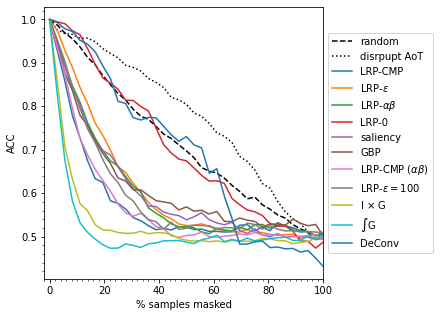

In [26]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from matplotlib.ticker import MultipleLocator
ml = MultipleLocator(5)
import matplotlib.ticker as tck

metric='acc'

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(perm_random['samples'], np.mean(perm_random[metric], axis=0),'--', label='random', color='k')
#ax.plot(perm_random_AoT_fwd['samples'], np.mean(perm_random_AoT_fwd[metric], axis=0),':', label='disrupt AoT, fwd')
#ax.plot(perm_random_AoT_rev['samples'], np.mean(perm_random_AoT_rev[metric], axis=0),':', label='disrupt AoT, rev')
ax.plot(perm_random['samples'], np.mean(np.vstack((np.mean(perm_random_AoT_fwd[metric],  axis=0), np.mean(perm_random_AoT_rev[metric],  axis=0))), axis=0), ':', label='disrpupt AoT', color='k')
ax.plot(perm_lrp_cmp['samples'], np.mean(perm_lrp_cmp[metric], axis=0), '-', label=r'LRP-CMP')
ax.plot(perm_lrpe['samples'], np.mean(perm_lrpe[metric], axis=0), '-', label=r'LRP-$\epsilon$')
ax.plot(perm_lrpAB['samples'], np.mean(perm_lrpAB[metric], axis=0), '-', label=r'LRP-$\alpha\beta$')
ax.plot(perm_lrp0['samples'], np.mean(perm_lrp0[metric], axis=0), '-', label=r'LRP-0')
ax.plot(perm_sal['samples'], np.mean(perm_sal[metric], axis=0), '-', label=r'saliency')
ax.plot(perm_gbp['samples'], np.mean(perm_gbp[metric], axis=0), '-', label=r'GBP')
ax.plot(perm_lrp_cmp_alphabeta['samples'], np.mean(perm_lrp_cmp_alphabeta[metric], axis=0), '-', label=r'LRP-CMP ($\alpha\beta$)')
ax.plot(perm_lrpe100['samples'], np.mean(perm_lrpe100[metric], axis=0), '-', label=r'LRP-$\epsilon=100$')
ax.plot(perm_ixg['samples'], np.mean(perm_ixg[metric], axis=0), '-', label=r'I $\times$ G')
ax.plot(perm_ig['samples'], np.mean(perm_ig[metric], axis=0), '-', label=r'$\int$G')
ax.plot(perm_deconv['samples'], np.mean(perm_deconv[metric], axis=0), '-', label=r'DeConv')


ax.set_ylabel(metric.upper())
ax.set_xlabel('% samples masked')
ax.set_xlim((-2, 100))
ax.yaxis.set_minor_locator(MultipleLocator(0.02))
ax.xaxis.set_minor_locator(MultipleLocator(2))

lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save files in pdf and eps format
#plt.savefig(home + SAVE_PATH + "/permutation_test.pdf", dpi=150,  bbox_extra_artists=(lgd,), bbox_inches='tight')
#plt.savefig(home + SAVE_PATH + "/permutation_test.svg", dpi=150,  bbox_extra_artists=(lgd,), bbox_inches='tight')
# svg backend currently ignores the dpi

plt.show()

## Plotting Selected Permutation Comparisons

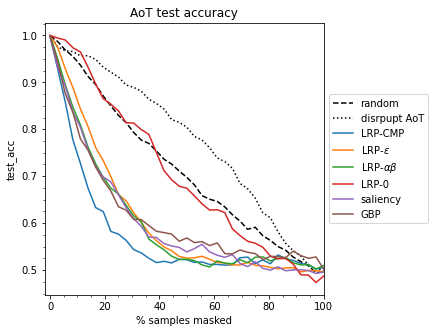

In [38]:
#to-do: change the colors to colorblind appropiate

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(perm_random['samples'], np.mean(perm_random[metric], axis=0),'--', label='random', color='k')
#ax.plot(perm_random_AoT_fwd['samples'], np.mean(perm_random_AoT_fwd[metric], axis=0),':', label='disrupt AoT, fwd', color='k')
#ax.plot(perm_random_AoT_rev['samples'], np.mean(perm_random_AoT_rev[metric], axis=0),':', label='disrupt AoT, rev', color='k')
ax.plot(perm_random['samples'], np.mean(np.vstack((np.mean(perm_random_AoT_fwd[metric],  axis=0), np.mean(perm_random_AoT_rev[metric],  axis=0))), axis=0), ':', label='disrpupt AoT', color='k')
ax.plot(perm_lrp_cmp['samples'], np.mean(perm_lrp_cmp[metric], axis=0), '-', label=r'LRP-CMP')
ax.plot(perm_lrpe['samples'], np.mean(perm_lrpe[metric], axis=0), '-', label=r'LRP-$\epsilon$')
ax.plot(perm_lrpAB['samples'], np.mean(perm_lrpAB[metric], axis=0), '-', label=r'LRP-$\alpha\beta$')
ax.plot(perm_lrp0['samples'], np.mean(perm_lrp0[metric], axis=0), '-', label=r'LRP-0')
ax.plot(perm_sal['samples'], np.mean(perm_sal[metric], axis=0), '-', label=r'saliency')
ax.plot(perm_gbp['samples'], np.mean(perm_gbp[metric], axis=0), '-', label=r'GBP')
#ax.plot(perm_lrp_cmp_alphabeta['samples'], np.mean(perm_lrp_cmp_alphabeta[metric], axis=0), '-', label=r'LRP-CMP ($\alpha\beta$)')
#ax.plot(perm_lrpe100['samples'], np.mean(perm_lrpe100[metric], axis=0), '-', label=r'LRP-$\epsilon=100$')
#ax.plot(perm_ixg['samples'], np.mean(perm_ixg[metric], axis=0), '-', label=r'I $\times$ G')
#ax.plot(perm_ig['samples'], np.mean(perm_ig[metric], axis=0), '-', label=r'$\int$G')
#ax.plot(perm_deconv['samples'], np.mean(perm_deconv[metric], axis=0), '-', label=r'DeConv')

ax.set_ylabel('test_acc')
ax.set_xlabel('% samples masked')
ax.set_xlim((-2, 100))
ax.yaxis.set_minor_locator(MultipleLocator(0.025))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.set_title('AoT test accuracy')
lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save files in pdf and eps format
plt.savefig(PERM_SAVE_PATH + "/permutation_test.pdf", dpi=150,  bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(PERM_SAVE_PATH + "/permutation_test.svg", dpi=150,  bbox_extra_artists=(lgd,), bbox_inches='tight')
# svg backend currently ignores the dpi

plt.show()